# Week 9 Class 1: Example 8.3

Read in the data from the Excel file `w09-c01-nonlinear-models.xlsx` sheet `Linear 8.3`. Now how we were able to just pull in the columns we wanted and skip the extra rows at the top. Note in our example, we are given historical data where x=degree days (how many days below “comfortable” 68° where heating is generally needed) and y=gas consumption. We want to predict consumption from degree days.

## Load Needed Packages

In [1]:
import pyomo.environ as pe
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Read in the data first - note focusing just on columns and rows we want
df = pd.read_excel('w09-c01-nonlinear-models.xlsx', sheet_name = 'Linear 8.3', 
                     skiprows = 8, usecols = 'B:C')
df

,Days,Consumed
0,10,51
1,11,63
2,13,89
3,15,123
4,19,146
5,22,157
6,24,141
7,25,169
8,25,172
9,28,163


Suppose we want to fit this model using 2 equations:
* Linear Model: y = a + bx
* Power Model: y = (ax)^b 

**NOTE** they both have two decision variables `a` and `b` and their specific objective functions (above). We will build the models separately.

## 1. Create a scatterplot
Plot Days (x) versus Consumed (y) using `seaborn`. 

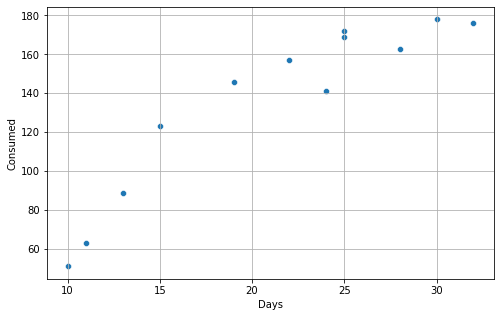

In [3]:
plt.figure(figsize = (8,5))
sns.scatterplot(x = 'Days', y = 'Consumed', data = df)
plt.grid()
plt.show()
plt.show()

## 2. Solve with a linear model 
For the linear model we will minimize the sum of the squared differences (y - predy)^2. We will sum across all the rows.

* **y** = original Gas Consumption
* **predy** = a + bx

**NOTE** in python `**` is how you raise to a power `^`.

### Define the model

In [4]:
model_lin = pe.ConcreteModel()

# variables
model_lin.a = pe.Var(domain = pe.NonNegativeReals)
model_lin.b = pe.Var(domain = pe.NonNegativeReals)
                
# Objective function: (y - (a + bx))^2 where predy = a + bx
data_rows = range(12) #create the index row names 0 to 11
model_lin.obj = pe.Objective(expr = sum((df.loc[row,'Consumed'] - 
                                         (model_lin.a + model_lin.b * df.loc[row,'Days']))**2
                                        for row in data_rows), sense = pe.minimize)

In [5]:
model_lin.pprint() 

2 Var Declarations
    a : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :  None : False :  True : NonNegativeReals
    b : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :  None : False :  True : NonNegativeReals

1 Objective Declarations
    obj : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : minimize : (51 - (a + 10*b))**2 + (63 - (a + 11*b))**2 + (89 - (a + 13*b))**2 + (123 - (a + 15*b))**2 + (146 - (a + 19*b))**2 + (157 - (a + 22*b))**2 + (141 - (a + 24*b))**2 + (169 - (a + 25*b))**2 + (172 - (a + 25*b))**2 + (163 - (a + 28*b))**2 + (178 - (a + 30*b))**2 + (176 - (a + 32*b))**2

3 Declarations: a b obj


### Solve the model

In [6]:
opt = pe.SolverFactory('ipopt')
result = opt.solve(model_lin)
print(result.solver.status, result.solver.termination_condition)

ok optimal


### View optimal a, b, and minimized squared error (optimal obj function)

In [7]:
print('The Optimal Values')
obj_val = model_lin.obj.expr()
print(f'optimal objective value = {obj_val:.1f}')
print()
print(f'The optimal a value is {model_lin.a.value:.1f}')
print(f'The optimal b value is {model_lin.b.value:.1f}')

The Optimal Values
optimal objective value = 3053.0

The optimal a value is 18.5
The optimal b value is 5.5


### Add the predicted values to the `data` table.

Now, let's add calculated the predicted values with our equation with our optimal `a` and `b` values so we can add them to the scatterplot.

Put the values in a column called "Linear".

In [8]:
df['Linear'] = model_lin.a.value + model_lin.b.value*df['Days']
df

,Days,Consumed,Linear
0,10,51,73.861306
1,11,63,79.396114
2,13,89,90.465731
3,15,123,101.535348
4,19,146,123.674582
5,22,157,140.279007
6,24,141,151.348624
7,25,169,156.883432
8,25,172,156.883432
9,28,163,173.487858


### Add the new values to the scatterplot

Redo the scatterplot and add the new data points in red. HINT: Copy your previous code and now add a new `plt.scatter` function below your previous. And this time put in your Days and predicted Linear values. Make the new points red and add the label `'Linear'`.

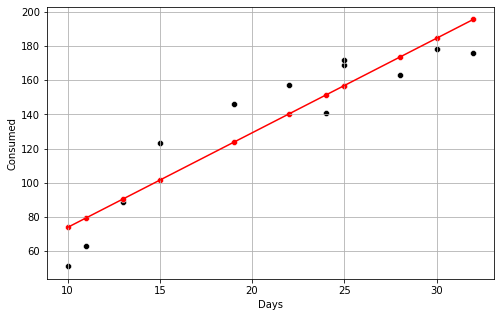

In [9]:
plt.figure(figsize = (8,5))
sns.scatterplot(x = 'Days', y = 'Consumed', data = df, color = 'black')
sns.scatterplot(x = 'Days', y = 'Linear', data = df, color = 'red')
sns.lineplot(x = 'Days', y = 'Linear', data = df, color = 'red')
plt.grid()
plt.show()

## 3. Solve with a power model

For the power model we will still minimize the sum of the squared differences (y - predy)^2. We will sum across all the rows.

* **y** = original Gas Consumption
* **predy** = (ax)^b

**NOTE** in python `**` is how you raise to a power `^`.

Now, create a new model `model_pow` that fits `a` and `b` using the power equation. 
* Solve the model
* Output the optimal objective function and decision variables
* Add the new predicted points to the `data` table and a scatterplot. Color them blue and add the label `'power'`.

### Solve the model

In [10]:
model_pow = pe.ConcreteModel()

# Decision variables
model_pow.a = pe.Var(domain = pe.NonNegativeReals)
model_pow.b = pe.Var(domain = pe.NonNegativeReals)
                
# Objective function: (y - predy)^2 where predy = ax^b
data_rows = range(12) #create the index row names 0 to 11

model_pow.obj = pe.Objective(expr = sum((df.loc[row, 'Consumed'] - 
                                         model_pow.a*(df.loc[row, 'Days'])**model_pow.b)**2
                                        for row in data_rows), 
                             sense = pe.minimize)

In [11]:
model_pow.pprint()

2 Var Declarations
    a : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :  None : False :  True : NonNegativeReals
    b : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :  None : False :  True : NonNegativeReals

1 Objective Declarations
    obj : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : minimize : (51 - a*10**b)**2 + (63 - a*11**b)**2 + (89 - a*13**b)**2 + (123 - a*15**b)**2 + (146 - a*19**b)**2 + (157 - a*22**b)**2 + (141 - a*24**b)**2 + (169 - a*25**b)**2 + (172 - a*25**b)**2 + (163 - a*28**b)**2 + (178 - a*30**b)**2 + (176 - a*32**b)**2

3 Declarations: a b obj


In [12]:
result = opt.solve(model_pow)
print(result.solver.status, result.solver.termination_condition)

ok optimal


### Output the optimal objective function and decision variables

In [13]:
print('The Optimal Values')
obj_val = model_pow.obj.expr()
print(f'optimal objective value = {obj_val:.4f}')
print()
print(f'The optimal a value is {model_pow.a.value:.2f}')
#print(f'The optimal a value is {model_pow.a.value}')
print(f'The optimal b value is {model_pow.b.value:.2f}')

The Optimal Values
optimal objective value = 2742.5370

The optimal a value is 11.52
The optimal b value is 0.81


### Add the new predicted points to the data table and a scatterplot.

In [14]:
df['Power'] = model_pow.a.value * df['Days']**model_pow.b.value
df

,Days,Consumed,Linear,Power
0,10,51,73.861306,74.756706
1,11,63,79.396114,80.772640
2,13,89,90.465731,92.508392
3,15,123,101.535348,103.908274
4,19,146,123.674582,125.898350
5,22,157,140.279007,141.815711
6,24,141,151.348624,152.198942
7,25,169,156.883432,157.329003
8,25,172,156.883432,157.329003
9,28,163,173.487858,172.495473


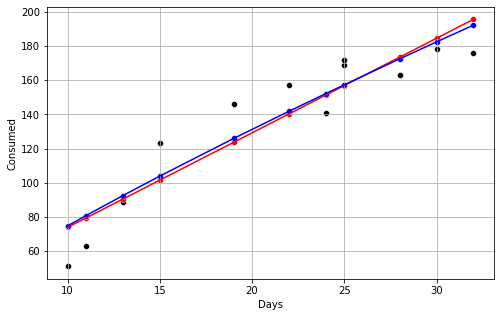

In [15]:
plt.figure(figsize = (8, 5))
sns.scatterplot(x = 'Days', y = 'Consumed', data = df, color = 'black')
sns.scatterplot(x = 'Days', y = 'Linear', data = df, color = 'red')
sns.scatterplot(x = 'Days', y = 'Power', data = df, color = 'blue')
sns.lineplot(x = 'Days', y = 'Linear', data = df, color = 'red')
sns.lineplot(x = 'Days', y = 'Power', data = df, color = 'blue')
plt.grid()
plt.show()

Try doing the same thing as above by `melt`ing the dataframe.

In [16]:
df_new = pd.melt(df, 'Days')
df_new

,Days,variable,value
0,10,Consumed,51.000000
1,11,Consumed,63.000000
2,13,Consumed,89.000000
3,15,Consumed,123.000000
4,19,Consumed,146.000000
5,22,Consumed,157.000000
6,24,Consumed,141.000000
7,25,Consumed,169.000000
8,25,Consumed,172.000000
9,28,Consumed,163.000000


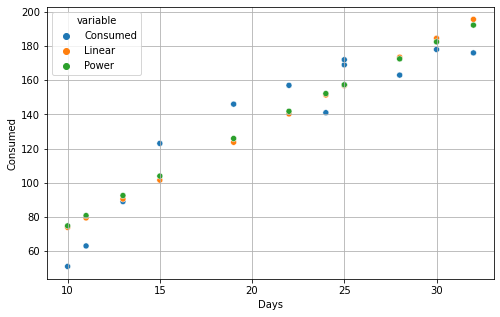

In [17]:
plt.figure(figsize = (8, 5))
sns.scatterplot(x = 'Days', y = 'value', hue = 'variable', data = df_new)
plt.grid()
plt.xlabel("Days")
plt.ylabel("Consumed")
plt.show()
